In [17]:
import sys
sys.path.append("..")
from semif_utils.segment_utils import get_image_meta, prep_bbox
import os
from pathlib import Path
import matplotlib.pyplot as plt
import random
os.chdir("/home/weedsci/matt/SemiF-AnnotationPipeline")

'/home/weedsci/matt/SemiF-AnnotationPipeline'

In [26]:
metadir = Path("./data/semifield-developed-images/MD_2022-07-01/metadata/")
# random.seed(42)
rdn = random.randint(0,200)
labels = [str(x) for x in (metadir).glob("*.json")][rdn]
imgdata = get_image_meta(labels)
# Call image array
rgb_array = imgdata.array
# Get bboxes
bboxes = imgdata.bboxes


In [28]:
## Process on images by individual bbox detection
cutout_num = 0
cutout_ids = []

# for box in bboxes:
for box in bboxes:
    scale = [imgdata.fullres_width, imgdata.fullres_height]
    prep_box, x1, y1, x2, y2 = prep_bbox(box, scale)
    # Crop image to bbox
    rgb_crop = rgb_array[y1:y2, x1:x2]
    # plt.imshow(rgb_crop)
    # plt.show()

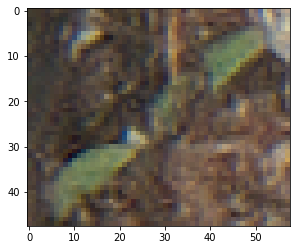